In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('qb_stats.csv')

df.columns = df.columns.str.lower()
df['player'] = df['player'].apply(lambda x: ' '.join(x.split()[:-1]))
df['firstName'] = df.player.str.split().str[0]
df['lastName'] = df.player.str.split().str[1]
df.yds = pd.to_numeric(df.yds.str.replace(',', ''))
df['yds.1'] = pd.to_numeric(df['yds.1'].str.replace(',', ''))

df.head()

,rank,player,cmp,att,pct,yds,y/a,td,int,sacks,...,yds.1,td.1,fl,g,fpts,fpts/g,own,year,firstName,lastName
0,1,Patrick Mahomes II,383,580,66.0,5097,8.8,50,12,26,...,272,2,2,16,417.0,26.1,99.9%,2018,Patrick,Mahomes
1,2,Matt Ryan,422,608,69.4,4924,8.1,35,7,42,...,125,3,5,16,354.0,22.1,6.1%,2018,Matt,Ryan
2,3,Ben Roethlisberger,452,675,67.0,5129,7.6,34,16,24,...,98,3,2,16,341.0,21.3,13.6%,2018,Ben,Roethlisberger
3,4,Deshaun Watson,345,505,68.3,4165,8.2,26,9,62,...,551,5,3,16,331.9,20.7,92.5%,2018,Deshaun,Watson
4,5,Andrew Luck,430,639,67.3,4593,7.2,39,15,18,...,148,0,1,16,327.1,20.4,2.2%,2018,Andrew,Luck


In [3]:
def clean_pass_file(df, year):
    new_df = df.copy()
    new_df.Player = new_df.Player.str.replace('[*+]', '', regex = True)
    new_df['firstName'] = new_df.Player.str.split().str[0]
    new_df['lastName'] = new_df.Player.str.split().str[1]
    new_df['year'] = year
    new_df = new_df[['Tm', 'Age', 'firstName', 'lastName', 'year', ]]
    
    return new_df

In [4]:
df_18 = pd.read_csv('qb_2018.txt')
df_clean_18 = clean_pass_file(df_18, 2018)

df_19 = pd.read_csv('qb_2019.txt')
df_clean_19 = clean_pass_file(df_19, 2019)

df_20 = pd.read_csv('qb_2020.txt')
df_clean_20 = clean_pass_file(df_20, 2020)

df_21 = pd.read_csv('qb_2021.txt')
df_clean_21 = clean_pass_file(df_21, 2021)

df_22 = pd.read_csv('qb_2022.txt')
df_clean_22 = clean_pass_file(df_22, 2022)

# Concat and Merge Dataframes

In [5]:
# concat and merge dataframes
df = df.copy()
df_combined = pd.concat([df_clean_18, df_clean_19, df_clean_20, df_clean_21, df_clean_22], ignore_index = True)
df_merged = pd.merge(df, df_combined, on = ['firstName', 'lastName', 'year'], how = 'left')

# filter down to running backs who play
df_merged = df_merged[(df_merged.att > 50) & (df_merged.fpts > 0)]
df_merged.sort_values(by  = 'fpts', ascending = False).head()

,rank,player,cmp,att,pct,yds,y/a,td,int,sacks,...,fl,g,fpts,fpts/g,own,year,firstName,lastName,Tm,Age
333,1,Patrick Mahomes II,435,648,67.1,5250,8.1,41,12,26,...,0,17,428.4,25.2,99.9%,2022,Patrick,Mahomes,KAN,27.0
77,1,Lamar Jackson,265,401,66.1,3127,7.8,36,6,23,...,2,15,421.7,28.1,99.6%,2019,Lamar,Jackson,BAL,22.0
250,1,Josh Allen,409,646,63.3,4407,6.8,36,15,26,...,3,17,417.7,24.6,99.9%,2021,Josh,Allen,BUF,25.0
0,1,Patrick Mahomes II,383,580,66.0,5097,8.8,50,12,26,...,2,16,417.0,26.1,99.9%,2018,Patrick,Mahomes,KAN,23.0
334,2,Josh Allen,362,573,63.2,4316,7.5,35,14,33,...,5,17,412.4,24.3,99.9%,2022,Josh,Allen,BUF,26.0


In [6]:
df_pvt = df.pivot_table(index = ['firstName', 'lastName'], columns = 'year', values = 'fpts/g')
df_pvt.columns = ['fpts_2018', 'fpts_2019', 'fpts_2020', 'fpts_2021', 'fpts_2022']
df_pvt.reset_index(inplace = True)
df_pvt.head()

,firstName,lastName,fpts_2018,fpts_2019,fpts_2020,fpts_2021,fpts_2022
0,AJ,McCarron,0.0,6.0,0.4,NaN,NaN
1,Aaron,Rodgers,19.5,17.6,24.2,21.0,14.8
2,Adam,Froman,NaN,NaN,NaN,NaN,0.0
3,Adrian,Martinez,NaN,NaN,NaN,NaN,0.0
4,Aidan,O'Connell,NaN,NaN,NaN,NaN,0.0


In [7]:
df_fpts = pd.merge(df_merged, df_pvt, on = ['firstName', 'lastName'], how = 'left').dropna()
df_fpts.head()

,rank,player,cmp,att,pct,yds,y/a,td,int,sacks,...,year,firstName,lastName,Tm,Age,fpts_2018,fpts_2019,fpts_2020,fpts_2021,fpts_2022
0,1,Patrick Mahomes II,383,580,66.0,5097,8.8,50,12,26,...,2018,Patrick,Mahomes,KAN,23.0,26.1,20.9,25.4,22.0,25.2
1,2,Matt Ryan,422,608,69.4,4924,8.1,35,7,42,...,2018,Matt,Ryan,ATL,33.0,22.1,18.8,18.3,13.8,14.0
5,6,Aaron Rodgers,372,597,62.3,4442,7.4,25,2,49,...,2018,Aaron,Rodgers,GNB,35.0,19.5,17.6,24.2,21.0,14.8
6,7,Jared Goff,364,561,64.9,4688,8.4,32,12,33,...,2018,Jared,Goff,LAR,24.0,19.4,16.5,16.9,14.5,17.1
8,9,Russell Wilson,280,427,65.6,3448,8.1,35,7,51,...,2018,Russell,Wilson,SEA,30.0,18.7,20.8,23.3,17.8,15.7


In [8]:
np.unique(df_fpts.Tm)

array(['2TM', 'ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE',
       'DAL', 'DEN', 'DET', 'GNB', 'HOU', 'IND', 'JAX', 'KAN', 'LAR',
       'LVR', 'MIA', 'MIN', 'NOR', 'NWE', 'NYG', 'NYJ', 'OAK', 'PHI',
       'SEA', 'SFO', 'TAM', 'TEN', 'WAS'], dtype=object)

In [9]:
# final 2019 rankings according to ProFootballFocus
# https://www.pff.com/news/nfl-offensive-line-rankings-following-2019-regular-season
off_line_ranks_19 = {'PHI':1, 'BAL':2, 'IND':3, 'DAL':4, 'NOR':5, 'GNB':6,
                     'TAM':7, 'TEN':8, 'PIT':9, 'NWE':10, 'DET':11, 'DEN':12,
                     'WAS':13, 'SFO':14, 'LV':15, 'KAN':16, 'NYG':17, 'CAR':18,
                     'MIN':19, 'HOU':20, 'BUF':21, 'ARI':22, 'CLE':23, 'ATL':24,
                     'CHI':25, 'JAX':26, 'SEA':27, 'NYJ':28, 'LAC':29, 'CIN':30,
                     'LAR':31, 'MIA':32, 'FA':33}

# final 2020 o-line rankings according to ProFootballFocus(PFF)
# https://www.pff.com/news/nfl-final-2020-offensive-line-rankings
off_line_ranks_20 = {'CLE':1, 'GNB':2, 'LAR':3, 'NWE':4, 'TAM':5, 'WAS':6, 'IND':7,
                  'NOR':8, 'SFO':9, 'BUF':10, 'KAN':11, 'ARI':12, 'DET':13, 
                  'SEA': 14, 'TEN': 15, 'BAL': 16, 'PIT': 17, 'CAR': 18, 'PHI': 19,
                  'CHI': 20, 'ATL': 21, 'JAX': 22, 'HOU': 23, 'LV': 24, 'DEN': 25,
                  'MIN': 26, 'DAL': 27, 'MIA': 28, 'NYJ': 29, 'CIN': 30, 'NYG':31,
                  'LAC': 32, 'FA': 33}

# WR group ranking entering the 2019 season according to PFF
# https://www.pff.com/news/pro-nfl-receiving-corps-rankings-all-32-teams-entering-2019
wr_group_ranks_19 = {'PHI':1, 'ATL':2, 'LAR':3, 'KAN':4, 'HOU':5, 'CLE':6,
                     'TAM':7, 'MIN':8, 'LAC':9, 'CIN':10, 'CHI':11, 'LV':12,
                     'NOR':13, 'PIT':14, 'DET':15, 'DEN':16, 'TEN':17, 'SFO': 18,
                     'DAL':19, 'GNB':20, 'IND':21, 'CAR':22, 'BUF':23, 'ARI':24,
                     'SEA':25, 'NWE':26, 'NYG':27, 'WAS':28, 'NYJ':29, 'MIA':30,
                     'BAL':31, 'JAX':32, 'FA': 33}

# WR group ranking entering the 2020 season according to PFF
# https://www.pff.com/news/nfl-2020-nfl-season-receiving-corps-rankings
wr_group_ranks_20 = {'TAM':1, 'KAN':2, 'DAL':3, 'NOR':4, 'BUF':5, 'DET':6, 'LAC':7,
                     'CAR':8, 'CLE':9, 'DEN':10, 'CIN': 11, 'ARI':12, 'ATL':13,
                     'PHI':14, 'LAR':15, 'SFO':16, 'SEA':17, 'PIT':18, 'LV':19,
                     'HOU':20, 'NYG':21, 'IND':22, 'TEN':23, 'MIN':24, 'BAL':25,
                     'GNB':26, 'CHI':27, 'NYJ':28, 'MIA':29, 'NWE':30, 'JAX':31,
                     'WAS':32, 'FA': 33}

In [10]:
# convert rankings into dataframe

oline_19 = pd.DataFrame(off_line_ranks_19, index = [1]).transpose()\
                                                    .reset_index(drop = False)\
                                                    .rename(columns = {'index': 'Tm', 1: 'oline19_Rank'})

oline_20 = pd.DataFrame(off_line_ranks_20, index = [1]).transpose()\
                                                    .reset_index(drop = False)\
                                                    .rename(columns = {'index': 'Tm', 1: 'oline20_Rank'})

wr_19 = pd.DataFrame(wr_group_ranks_19, index = [1]).transpose()\
                                                    .reset_index(drop = False)\
                                                    .rename(columns = {'index': 'Tm', 1: 'wr19_Rank'})


wr_20 = pd.DataFrame(wr_group_ranks_20, index = [1]).transpose()\
                                                    .reset_index(drop = False)\
                                                    .rename(columns = {'index': 'Tm', 1: 'wr20_Rank'})
oline_19.head()

,Tm,oline19_Rank
0,PHI,1
1,BAL,2
2,IND,3
3,DAL,4
4,NOR,5


In [11]:
pred_df = df_fpts[df_fpts.year == 2019].copy()

# convert numeric columns to floats
for col in pred_df.columns:
    try:
        pred_df[col] = pd.to_numeric(pred_df[col])
    except Exception as e:
        print(f"Could not not convert {col} to float")
# pred_df[pred_df.Tm == 0] = 'CHI'
pred_df.loc[pred_df.Tm == 'OAK', 'Tm'] ='LV'
pred_df = pred_df[['player', 'yds', 'td', 'int', 'fpts', 'fpts/g', 'Tm', 'Age', 'fpts_2020']]
pred_df = pred_df[(pred_df['fpts/g'] > 5) & (pred_df.fpts_2020 > 5)]

pred_df.reset_index(drop=True)

Could not not convert player to float
Could not not convert own to float
Could not not convert firstName to float
Could not not convert lastName to float
Could not not convert Tm to float


,player,yds,td,int,fpts,fpts/g,Tm,Age,fpts_2020
0,Lamar Jackson,3127,36,6,421.7,28.1,BAL,22.0,22.8
1,Dak Prescott,4902,30,11,348.9,21.8,DAL,26.0,27.7
2,Russell Wilson,4110,31,5,333.5,20.8,SEA,31.0,23.3
3,Josh Allen,3089,20,9,297.5,18.6,BUF,23.0,25.3
4,Patrick Mahomes II,4031,26,5,291.9,20.9,KAN,24.0,25.4
5,Carson Wentz,4039,27,7,282.9,17.7,PHI,27.0,17.8
6,Aaron Rodgers,3994,26,4,282.0,17.6,GNB,36.0,24.2
7,Matt Ryan,4466,26,14,281.4,18.8,ATL,34.0,18.3
8,Tom Brady,4057,24,8,271.6,17.0,NWE,42.0,21.9
9,Jared Goff,4638,22,16,263.5,16.5,LAR,25.0,16.9


In [12]:
# join in rankings
pred_df = pd.merge(pred_df, oline_19, on = 'Tm', how = 'left')
pred_df = pd.merge(pred_df, oline_20, on = 'Tm', how = 'left')
pred_df = pd.merge(pred_df, wr_19, on = 'Tm', how = 'left')
pred_df = pd.merge(pred_df, wr_20, on = 'Tm', how = 'left')

# get diff in rankings
pred_df['olineDiff']= pred_df.oline19_Rank - pred_df.oline20_Rank
pred_df['wrDiff'] = pred_df.wr19_Rank - pred_df.wr20_Rank

pred_df.head()

,player,yds,td,int,fpts,fpts/g,Tm,Age,fpts_2020,oline19_Rank,oline20_Rank,wr19_Rank,wr20_Rank,olineDiff,wrDiff
0,Lamar Jackson,3127,36,6,421.7,28.1,BAL,22.0,22.8,2,16,31,25,-14,6
1,Dak Prescott,4902,30,11,348.9,21.8,DAL,26.0,27.7,4,27,19,3,-23,16
2,Russell Wilson,4110,31,5,333.5,20.8,SEA,31.0,23.3,27,14,25,17,13,8
3,Josh Allen,3089,20,9,297.5,18.6,BUF,23.0,25.3,21,10,23,5,11,18
4,Patrick Mahomes II,4031,26,5,291.9,20.9,KAN,24.0,25.4,16,11,4,2,5,2


In [13]:
pred_df = pred_df[['player', 'yds', 'td', 'int', 'fpts', 'fpts/g', 'Tm', 'Age', 'olineDiff', 'wrDiff', 'fpts_2020']]
pred_df.head()

,player,yds,td,int,fpts,fpts/g,Tm,Age,olineDiff,wrDiff,fpts_2020
0,Lamar Jackson,3127,36,6,421.7,28.1,BAL,22.0,-14,6,22.8
1,Dak Prescott,4902,30,11,348.9,21.8,DAL,26.0,-23,16,27.7
2,Russell Wilson,4110,31,5,333.5,20.8,SEA,31.0,13,8,23.3
3,Josh Allen,3089,20,9,297.5,18.6,BUF,23.0,11,18,25.3
4,Patrick Mahomes II,4031,26,5,291.9,20.9,KAN,24.0,5,2,25.4


# Explore Relationships

Exploring the relationship between a player's 2021 statististics and the impact it has on their 2022 performance

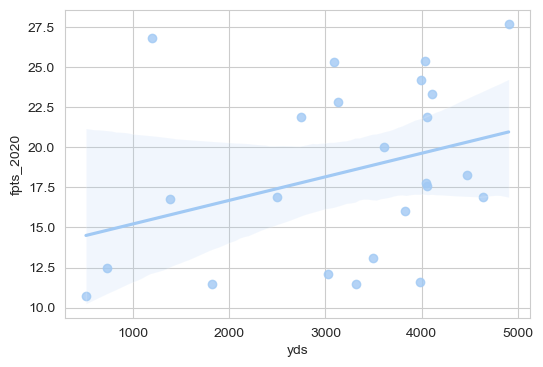

In [14]:
plt.figure(figsize=(6,4))
sns.regplot(data = pred_df, x = 'yds', y = 'fpts_2020')
plt.show()

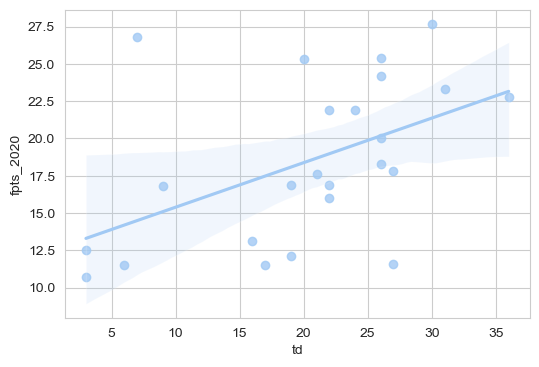

In [15]:
plt.figure(figsize=(6,4))
sns.regplot(data = pred_df, x = 'td', y = 'fpts_2020')
plt.show()

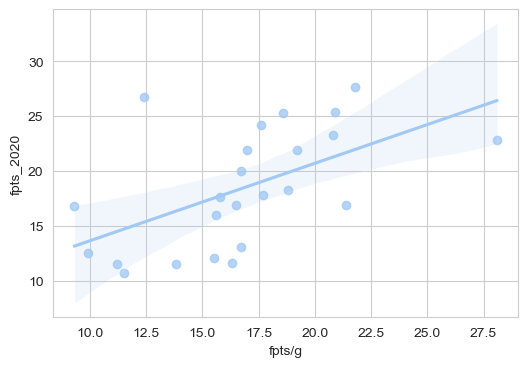

In [16]:
plt.figure(figsize=(6,4))
sns.regplot(data = pred_df, x = 'fpts/g', y = 'fpts_2020')
plt.show()

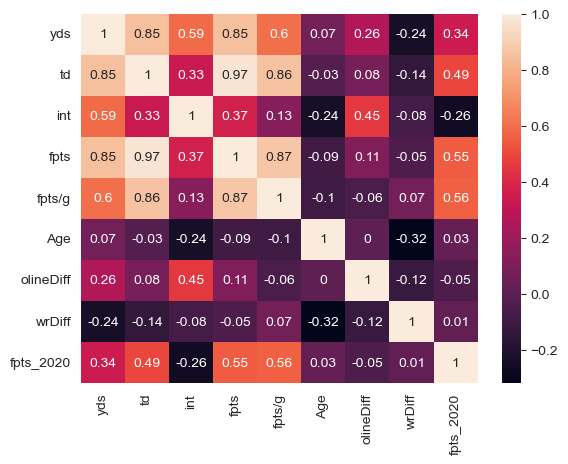

In [17]:
sns.heatmap(pred_df.corr().round(2), annot = True)
plt.show()

# Modeling

In [18]:
predictors = ['fpts/g', 'olineDiff', 'wrDiff']
target = 'fpts_2020'

X = pred_df[predictors]
y = pred_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

rf = RandomForestRegressor(n_estimators = 100, max_depth = 5, min_samples_split = 6)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_split=6)

In [19]:
df_test = pd.merge(X_test, y_test, how = 'inner', left_index = True, right_index = True)
df_test['RFPrediction'] = rf.predict(df_test[predictors])
df_test

,fpts/g,olineDiff,wrDiff,fpts_2020,RFPrediction
11,15.8,-9,-7,17.6,20.256355
16,15.5,-1,1,12.1,14.114522
5,17.7,-18,-13,17.8,21.911060
22,9.9,4,1,12.5,13.854232
4,20.9,5,2,25.4,21.591265
